# Imports and Data Preparation

Comparisions for RF-GAP
    - MALI
    - KEMA (MAT-LAB); wait


Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [141]:
from mashspud import MASH
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
from mashspud import SPUD
from rfgap import RFGAP
import matplotlib.pyplot as plt


#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="titanic.csv", split = "distort", percent_of_anchors= [0.2], verbose = 4, random_state= 42)

MDS initialized with 7 components

 
 
---------------------------       Initalizing class with titanic.csv data       ---------------------------

The knn values are: (2, 17, 32, 47, 62, 77, 92, 107, 122, 137)


In [148]:
np.unique(dc.split_A[:,-1])

array([0. , 0.5, 1. ])

In [47]:
def use_rf_proximities(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

# Applying RF GAP for SPUD

In [84]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 3, verbose = 4)

#Fit SPUD
spud_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:3])

Time it took to compute SGDM:  0.53
Time it took to execute graphtools.Graph functions:  0.17
Time it took to execute merge_graphs function:  0.0
Time it took to execute get_block function:  0.04
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


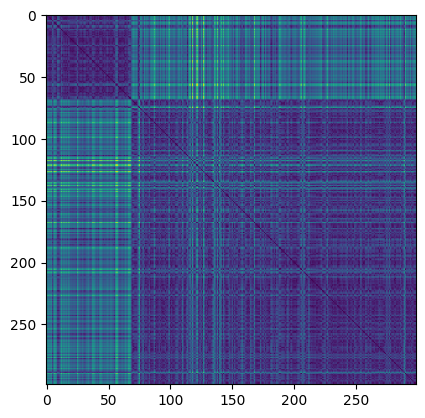

In [85]:
plt.imshow(spud_class.block[spud_class.len_A:, :spud_class.len_A])


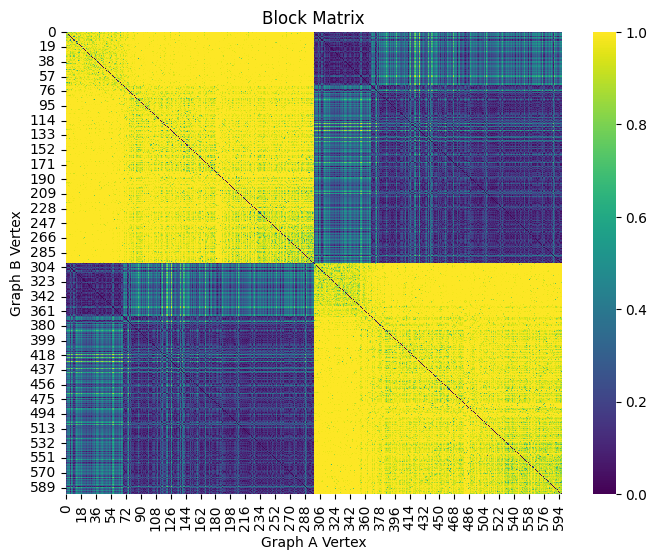

In [86]:
spud_class.plot_heat_map()

Time it took to calculate the embedding: 4.24
Calculating the classification Score.
Cross Embedding score: 0.8361204013377926
Fraction of Samples Closest to thier Match: 7.82989004597264e-05


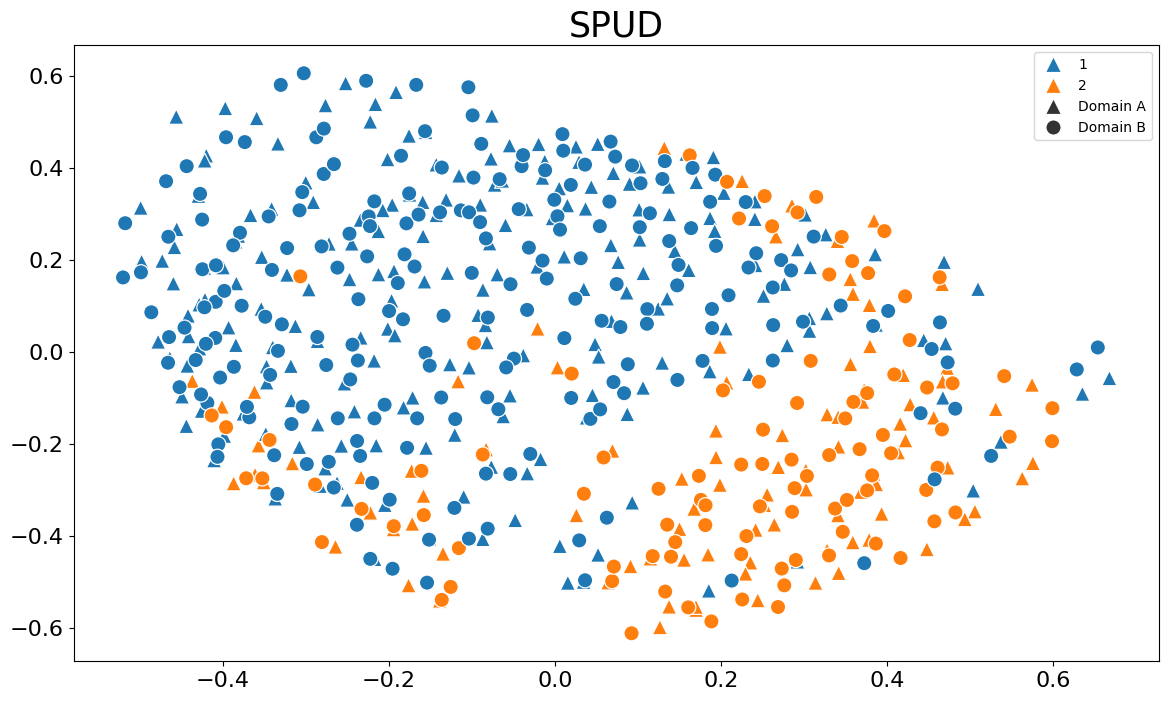

Time it took complete the plots: 0.2


In [87]:
spud_class.plot_emb(labels = dc.labels_doubled, show_anchors = False, show_lines = False)

# Applying RF GAP for MASH

In [126]:
#Create an RF Proximities function
def use_rf_proximities_MASH(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True) #Change Classification to regression

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

In [131]:
#Initialize SPUD Class
mash_class = MASH(distance_measure_A = use_rf_proximities_MASH, distance_measure_B= use_rf_proximities_MASH, knn = 3, verbose = 3, DTM = "log")

#Fit SPUD
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:10])

Time Data Below
 Time it took to execute SGDM for domain A:  0.22097
 Time it took to execute the graph for domain A:  0.0022
 Time it took to execute SGDM for domain B:  0.17548
 Time it took to execute the graph for domain B:  0.00176
 Time it took to compute merge_graphs function:  0.02419
 Time it took to compute similarity_matrix function:  0.00089
Using optimal t value of 15
 Time it took to compute diffusion process:  0.07363
Fit process finished. We recommend calling optimize_by_creating_connections.


Calculating the classification Score.
Cross Embedding score: 0.8165829145728642
Fraction of Samples Closest to thier Match: 0.1551981010580541


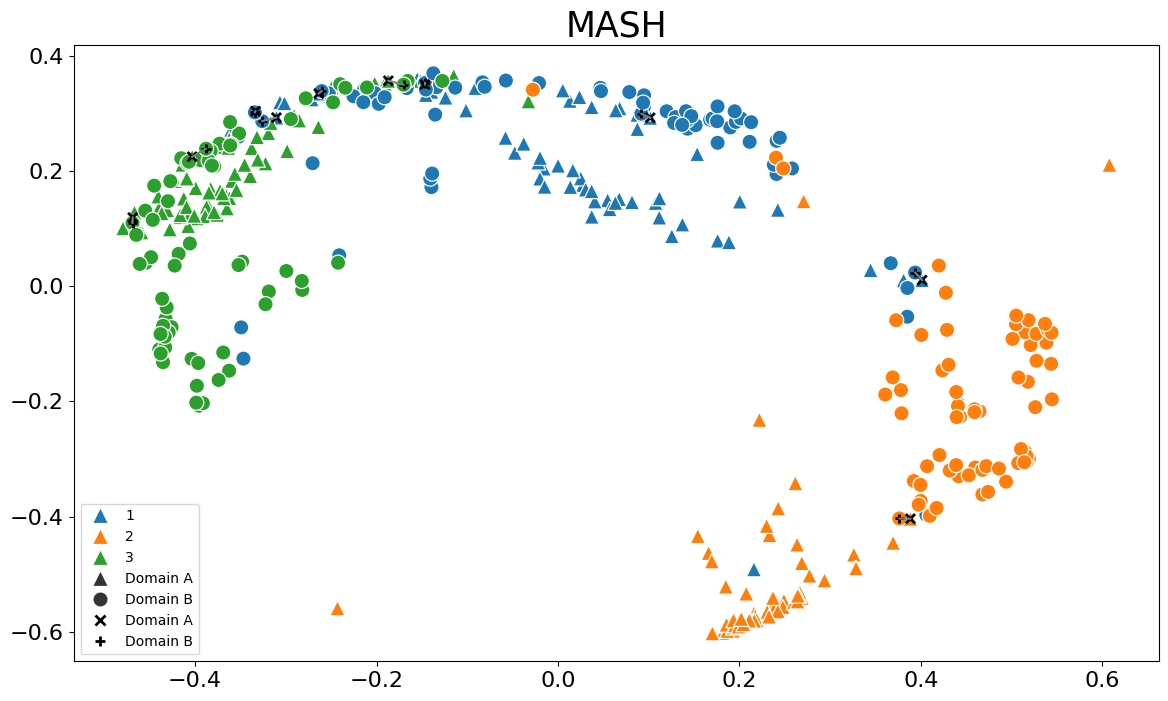

In [133]:
mash_class.plot_emb(labels = dc.labels_doubled, show_anchors = True, show_lines = False)

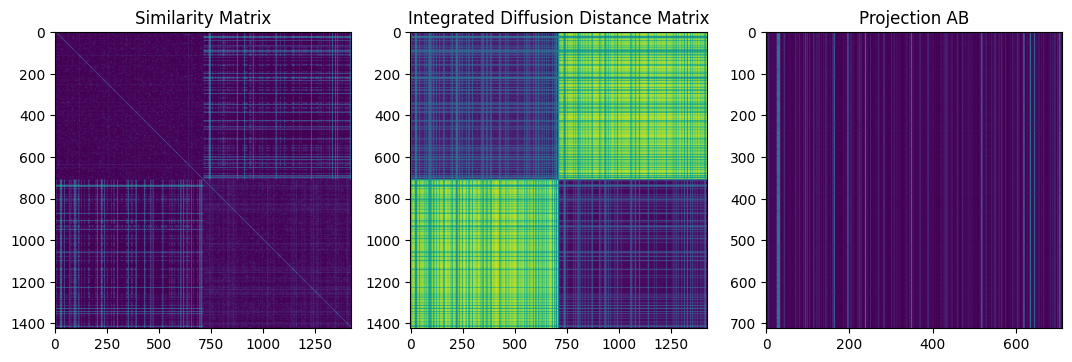

In [120]:
mash_class.plot_heat_maps()

Time Data Below
 Time it took to execute the graph for domain A:  0.08407
 Time it took to compute kernal A:  0.00173
 Time it took to execute the graph for domain B:  0.07979
 Time it took to compute kernal B:  0.00138


 Time it took to compute merge_graphs function:  0.22835
 Time it took to compute similarity_matrix function:  0.00851
Using optimal t value of 16
 Time it took to compute diffusion process:  1.22322
Fit process finished. We recommend calling optimize_by_creating_connections.


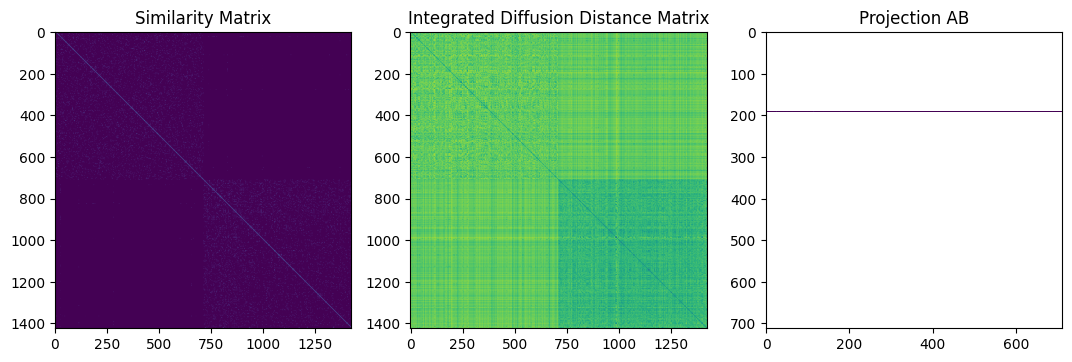

In [121]:
#Initialize SPUD Class
mash_class2 = MASH(knn = 8, verbose = 3, DTM = "log")
mash_class2.fit(dataA = dc.split_A, dataB = dc.split_B, known_anchors = dc.anchors[:4])
mash_class2.plot_heat_maps()

In [122]:
mash_class2.plot_emb(labels = dc.labels_doubled)

KeyboardInterrupt: 

<><><><><> Beggining Tests. Original Connections show below <><><><><>


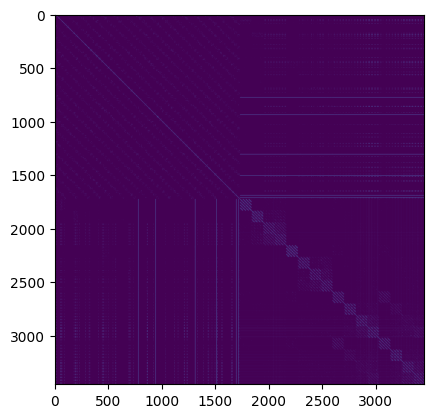

Edges wont be set with similarity measure above: 0.91
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 673578
New connections found: 30


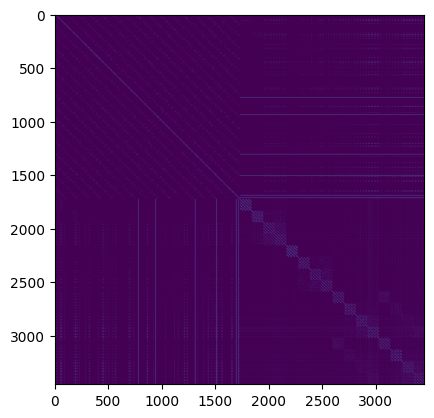

Using optimal t value of 8
The new connections worsened the alignment by 0.0011574074074073848
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 673578
New connections found: 30


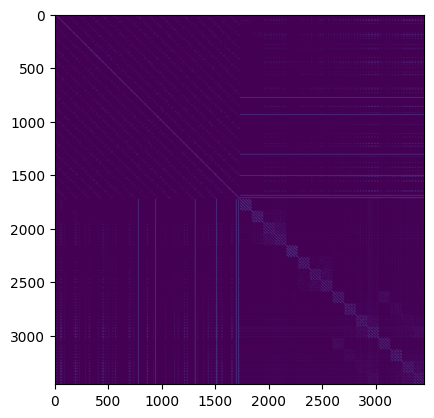

Using optimal t value of 8
The new connections worsened the alignment by 0.001880787037037035
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 2    <><><><><><><><><><><><><>
Total number of Known_connections: 673578
New connections found: 30


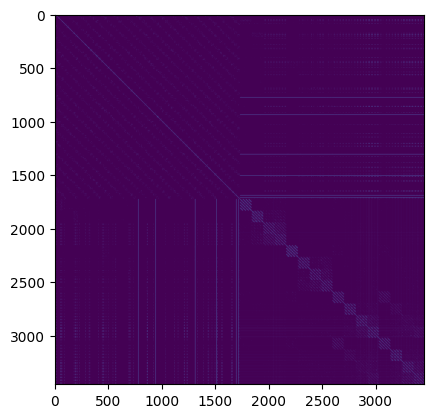

Using optimal t value of 8
The new connections worsened the alignment by 0.00209780092592593
-----------     Pruning the new connections. Continuing...    -----------

Using optimal t value of 8
Added Hold Out Anchor Conections


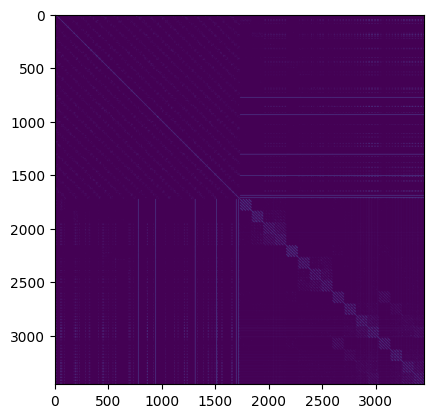

<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>


False

In [114]:
mash_class.optimize_by_creating_connections(epochs=3, connection_limit= 30, threshold = 0.9, hold_out_anchors=dc.anchors[4:8])

Calculating the classification Score.


Cross Embedding score: 0.5888310185185185
Fraction of Samples Closest to thier Match: 0.5027009521819273


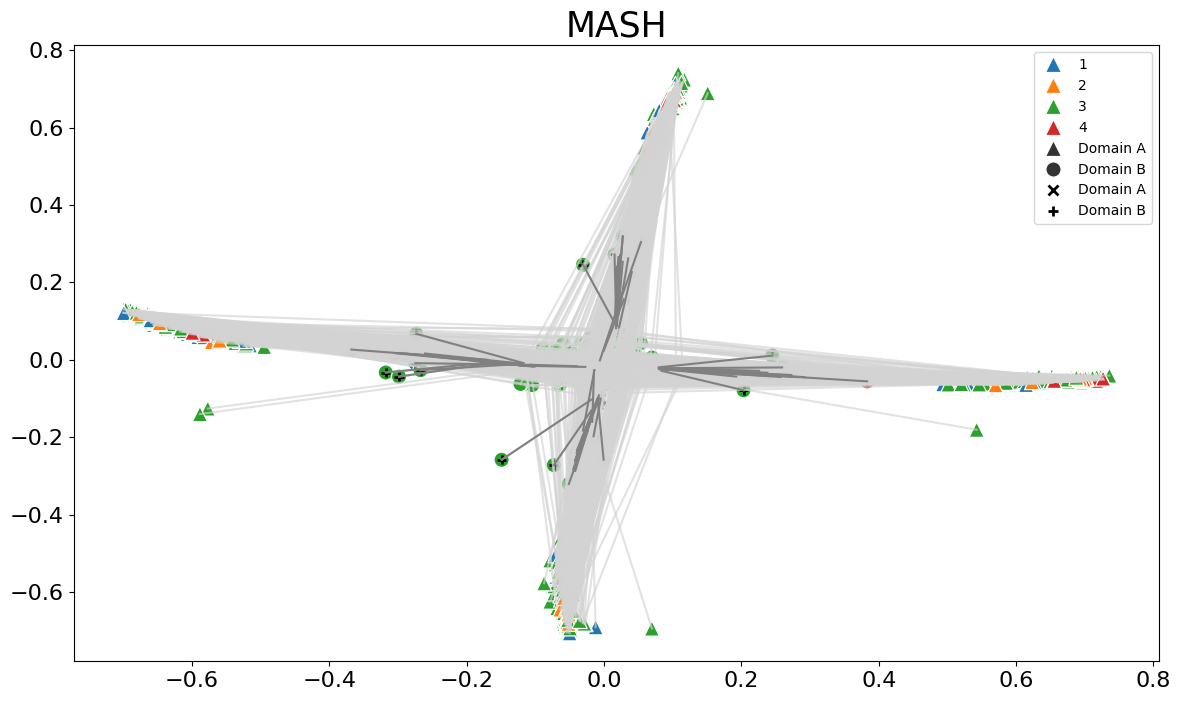

In [115]:
mash_class.plot_emb(labels = dc.labels_doubled)